This notebook contain the PSPNet model implementation. The implementation of this PSPNet details include:
- Training the model on 350 epoch
- The learning rate is set here to 0.02 and the batch size =8
- The optimizer choice is SGD with momentum
- the model  architecture summary can be found here : https://colab.research.google.com/drive/12PXwD91oChtQD4G24QZEH_kDpaRE_Bdd?usp=sharing

- Note : The model trained on the Colab Gpu , using another runtype choice might lead to variations on results





```
The code Libraries versions
NumPy version: 1.26.4
Pandas version: 2.2.2
TensorFlow version: 2.17.1
PyTorch version: 2.5.1+cu121
Segmentation Models PyTorch version: 0.3.4
OpenCV version: 4.10.0
Matplotlib version: 3.8.0
scikit-learn version: 1.6.0
Zipfile module version: Builtin module (No specific version)
os module version: Builtin module (No specific version)
```



If you run the code on google colab you have to run this snippet of code each session


```
!pip install segmentation-models-pytorch
```





---



#Visualizing Original Data

In [ ]:
import numpy as np
import pandas as pd


In [ ]:
import zipfile
import os

# Upload the zip file that conatin the data and then extract the file
print("Current working directory:", os.getcwd())

# Use an absolute path to the zip file:
zip_path = '/content/sorted_data.zip'
extract_path = '/content/sorted_data'

# Ensure this path actually exists before extracting:
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")


Current working directory: /content
Extracted to /content/sorted_data


In [ ]:
# List files in the extracted directory
!dir "/content/sorted_data"





content


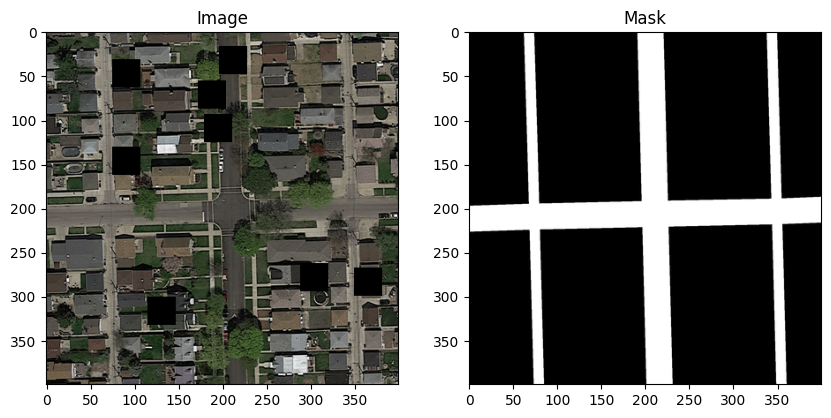

In [ ]:
#for loading the images and groundtruth

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the images and groundtruth directories
image_dir = '/content/sorted_data/content/sorted_images'
mask_dir = '/content/sorted_data/content/sorted_masks'

# List image files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Function to load an image and its corresponding mask
def load_image_mask(image_file, mask_file):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Read the image and the mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is grayscale

    return image, mask

# Load a sample image and mask
image, mask = load_image_mask(image_files[0], mask_files[0])

# Display the image and its corresponding mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.show()

#Libraries and File Paths

#Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (add, Activation, BatchNormalization, concatenate,
                                      Conv2D, Input, MaxPooling2D, UpSampling2D, ZeroPadding2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2


In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8d9c35e0c7b39e5fcfc817477e47eea927a7fea9fddab7a5d5b010fa89a98043
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=dd592f079a73b6b0089d431ffe053c511032829930bf89b61af72c7f058fc79a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#Preprocessing

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch import PSPNet

# Paths to image and mask directories
image_dir = '/content/sorted_data/content/sorted_images'
mask_dir = '/content/sorted_data/content/sorted_masks'

# Target sizes
input_size = (256, 256)
original_size = (400, 400)

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load file names
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Split data (80% train, 10% test, 10% val)
data_len = len(image_files)
train_size = int(0.8 * data_len)
test_size = val_size = (data_len - train_size) // 2

train_files = image_files[:train_size]
val_files = image_files[train_size:train_size + val_size]
test_files = image_files[train_size + val_size:]

train_masks = mask_files[:train_size]
val_masks = mask_files[train_size:train_size + val_size]
test_masks = mask_files[train_size + val_size:]

# Dataset Class
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, image_dir, mask_dir):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_dir = image_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        image = cv2.resize(image, input_size)
        image = image / 255.0

        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_size)
        mask = (mask > 127).astype(np.float32)

        image = np.transpose(image, (2, 0, 1))
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Create datasets
train_dataset = RoadSegmentationDataset(train_files, train_masks, image_dir, mask_dir)
val_dataset = RoadSegmentationDataset(val_files, val_masks, image_dir, mask_dir)
test_dataset = RoadSegmentationDataset(test_files, test_masks, image_dir, mask_dir)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



#Model Initialization

In [ ]:
# Model
model = PSPNet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    classes=1,
    activation="sigmoid"
)

# Dice Loss
def dice_loss(preds, targets, smooth=1):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return 1 - (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

# Function to compute F1 score
def compute_f1_score(outputs, masks):
    outputs = (outputs > 0.5).float().cpu().numpy().flatten()
    masks = masks.cpu().numpy().flatten()
    return f1_score(masks, outputs)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 240MB/s]


#Training and Validating The Model

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch import PSPNet
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
train_f1s = []
val_losses = []
val_f1s = []

# Training Loop
num_epochs = 350
save_path = "pspnet_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_f1 = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_f1 += compute_f1_score(outputs, masks)

    train_loss /= len(train_loader)
    train_f1 /= len(train_loader)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

    # Validation
    model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            val_loss += loss.item()
            val_f1 += compute_f1_score(outputs, masks)

    val_loss /= len(val_loader)
    val_f1 /= len(val_loader)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Save the model at the end of every epoch
    torch.save(model.state_dict(), save_path)




Epoch 1/350, Train Loss: 0.6785, Train F1: 0.3220, Val Loss: 0.6851, Val F1: 0.3148
Epoch 2/350, Train Loss: 0.6775, Train F1: 0.3224, Val Loss: 0.6850, Val F1: 0.3148
Epoch 3/350, Train Loss: 0.6696, Train F1: 0.3316, Val Loss: 0.6291, Val F1: 0.4076
Epoch 4/350, Train Loss: 0.5535, Train F1: 0.4612, Val Loss: 0.4729, Val F1: 0.5380
Epoch 5/350, Train Loss: 0.4058, Train F1: 0.6036, Val Loss: 0.3129, Val F1: 0.6942
Epoch 6/350, Train Loss: 0.3235, Train F1: 0.6824, Val Loss: 0.2775, Val F1: 0.7279
Epoch 7/350, Train Loss: 0.2841, Train F1: 0.7207, Val Loss: 0.2289, Val F1: 0.7770
Epoch 8/350, Train Loss: 0.2557, Train F1: 0.7491, Val Loss: 0.2076, Val F1: 0.7975
Epoch 9/350, Train Loss: 0.2336, Train F1: 0.7706, Val Loss: 0.1867, Val F1: 0.8178
Epoch 10/350, Train Loss: 0.2133, Train F1: 0.7908, Val Loss: 0.1654, Val F1: 0.8386
Epoch 11/350, Train Loss: 0.2039, Train F1: 0.8001, Val Loss: 0.1575, Val F1: 0.8464
Epoch 12/350, Train Loss: 0.1908, Train F1: 0.8128, Val Loss: 0.1482, Val 

#Model Evaluation on Test Train Val datasets

In [ ]:

# Testing
model.eval()
test_loss = 0.0
test_f1 = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        test_loss += loss.item()
        test_f1 += compute_f1_score(outputs, masks)

test_loss /= len(test_loader)
test_f1 /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}, Training F1: {train_f1s[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}, Validation F1: {val_f1s[-1]:.4f}")


Test Loss: 0.0301, Test F1: 0.9710
Final Training Loss: 0.0161, Training F1: 0.9852
Final Validation Loss: 0.0121, Validation F1: 0.9890


#Learning Curves

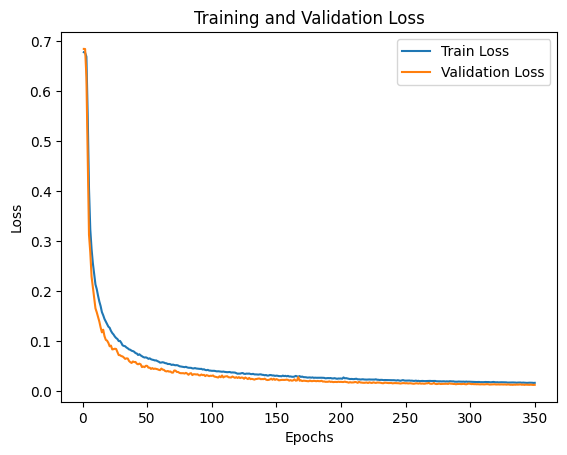

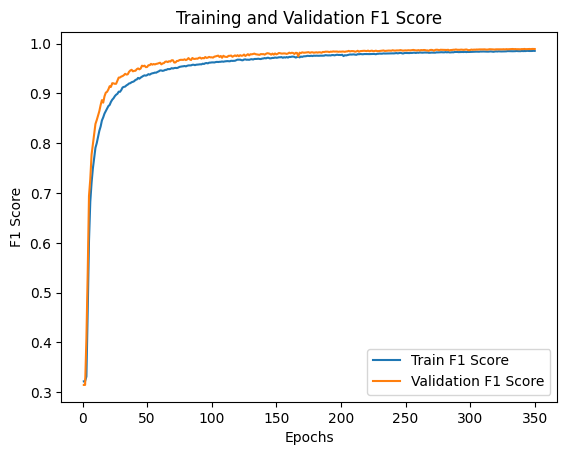

In [ ]:
# Plot Training and Validation Metrics
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_f1s, label="Train F1 Score")
plt.plot(epochs, val_f1s, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.show()


#Predicted Masks Visualization

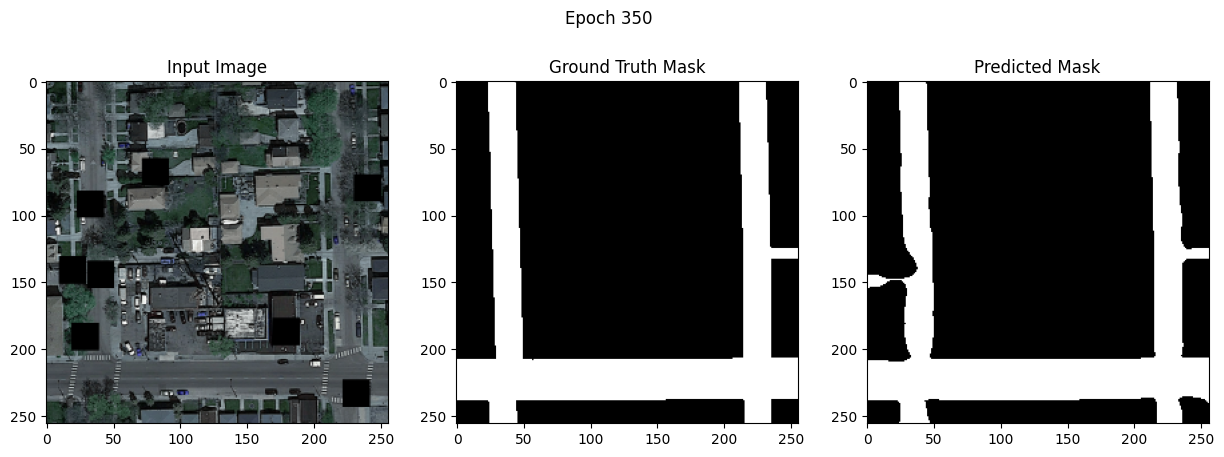

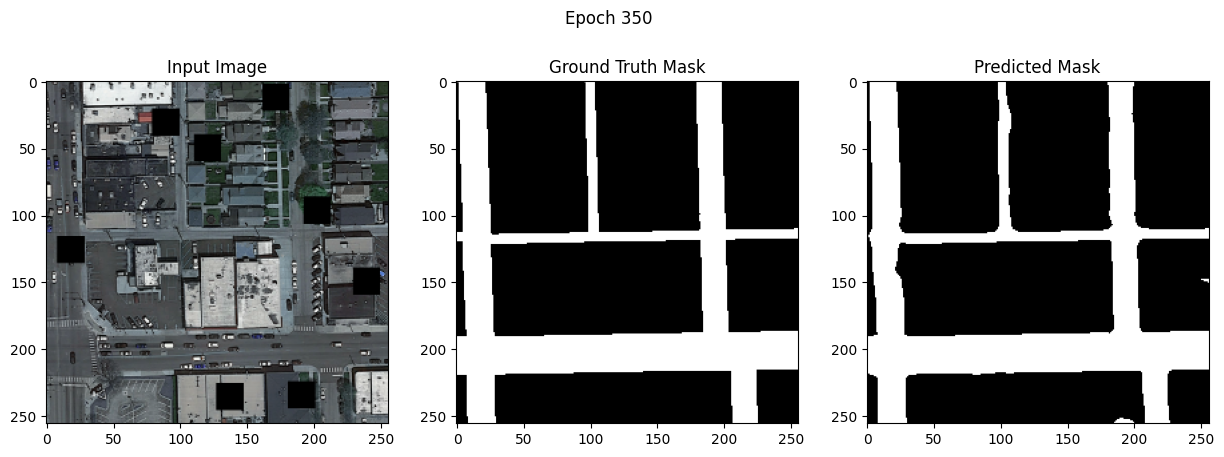

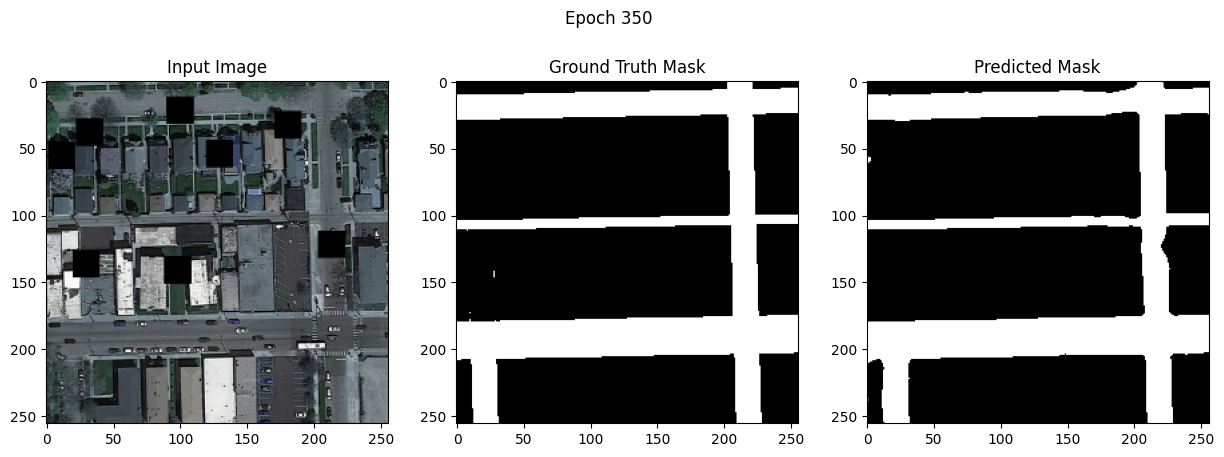

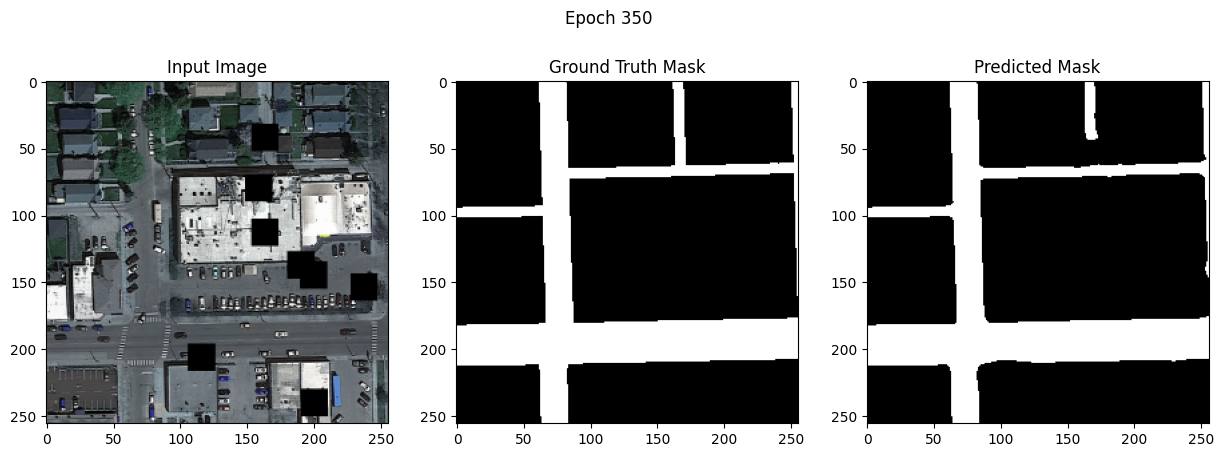

Test Loss: 0.0301, Test F1: 0.9710


In [ ]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(images, masks, predictions, epoch):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to (batch, H, W, C)
    masks = masks.cpu().numpy()
    predictions = (predictions > 0.5).float().cpu().numpy()

    for i in range(min(len(images), 4)):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[i])
        ax[0].set_title("Input Image")
        ax[1].imshow(masks[i, 0], cmap="gray")
        ax[1].set_title("Ground Truth Mask")
        ax[2].imshow(predictions[i, 0], cmap="gray")
        ax[2].set_title("Predicted Mask")
        plt.suptitle(f"Epoch {epoch+1}")
        plt.show()

# Add this after validation to visualize one batch of predictions
if epoch % 5 == 0:
    with torch.no_grad():
        images, masks = next(iter(val_loader))
        images, masks = images.to(device), masks.to(device)
        predictions = model(images)
        visualize_predictions(images, masks, predictions, epoch)



# Testing
model.eval()
test_loss = 0.0
test_f1 = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        test_loss += loss.item()
        test_f1 += compute_f1_score(outputs, masks)

    # Visualize test predictions
    visualize_predictions(images, masks, outputs, epoch)

test_loss /= len(test_loader)
test_f1 /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")